# CLIP-Image-Classification
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kingchloexx/CLIP-Image-Classification/blob/main/Multi_Domain_Pretrained_Classifier_with_CLIP.ipynb)

### restart runtime after running this cell


In [1]:
#@title setup libraries
import torch
import numpy as np
from PIL import Image
import os
import random
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import subprocess
InteractiveShell.ast_node_interactivity = "all"

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"
!git clone https://github.com/kingchloexx/CLIP-Image-Classification
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
# %cd /content/
# !git clone https://github.com/openai/CLIP.git
# %cd /content/CLIP/
!pip install ftfy
# !mv /content/CLIP /content/CLIP-Repo
# !mv /content/CLIP-Repo/clip /content/CLIP-Image-Classification/clip



CUDA version: 11.0
Cloning into 'CLIP-Image-Classification'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 26 (delta 3), reused 17 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.4MB/s eta 0:03:50tcmalloc: large alloc 1147494400 bytes == 0x558f762c6000 @  0x7f75bfa85615 0x558f3c57306c 0x558f3c652eba 0x558f3c575e8d 0x558f3c66799d 0x558f3c5e9fe9 0x558f3c5e4b0e 0x558f3c57777a 0x558f3c5e9e50 0x558f3c5e4b0e 0x558f3c57777a 0x558f3c5e686a 0x558f3c6687c6 0x558f3c5e5ee2 0x558f3c6687c6 0x558f3c5e5ee2 0x558f3c6687c6 0x558f3c5e5ee2 0x558f3c6687c6 0x558f3c6ea431 0x558f3c64b049 0x558f3c5b5c84 0x558f3c5768e9 0x558f3c5eaade 0x558f3c57769a 0x558f3c5e5a45 0x558f3c5e4e0d 0x558f3c57777a 0x558f3c5e5a45 0x558f3c57769a 0x558f3c5e5a45
     |█████████████████████████████▏  | 

### classify

/content/CLIP-Image-Classification
loading categories
classifying
strawberry


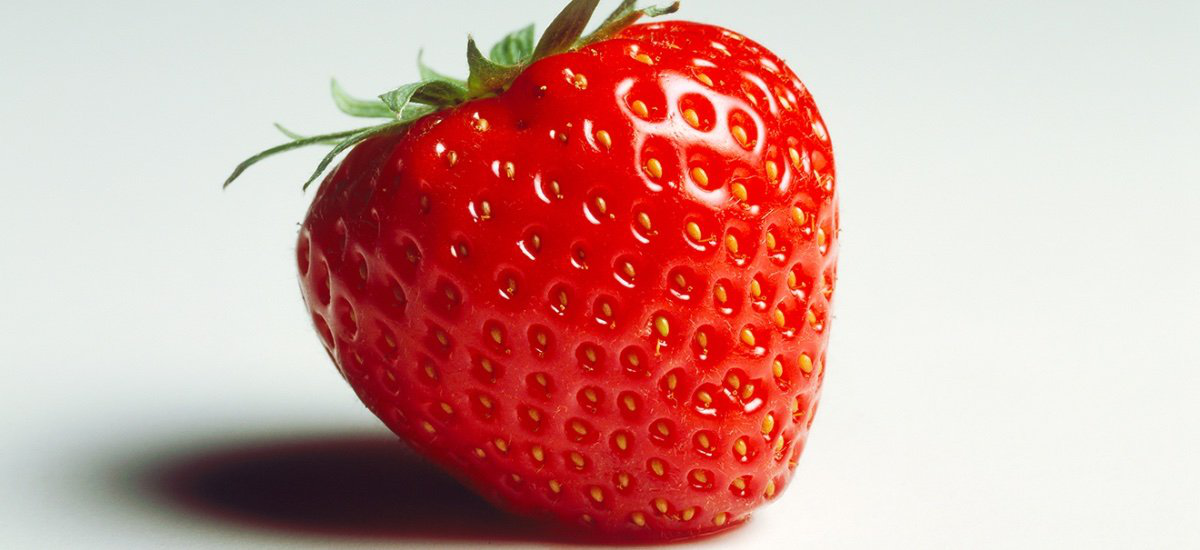

In [2]:
from PIL import Image
%cd /content/CLIP-Image-Classification
#download the image
image_url = "https://cdn.shopify.com/s/files/1/1266/9241/articles/10_health_and_wellness_benefits_of_strawberries_Story_Page.jpeg?v=1523561527"#@param {type:"string"}
!wget "$image_url" -O "input.jpg" -q

filename = "input.jpg"
load_categories = "imagenet" #@param ["imagenet", "dog vs cat", "pokemon", "words in the communist manifesto", "other (open this cell and write them into a list of strings)"]

from classify import load, classify
print("loading categories")
load(load_categories)
print("classifying")

print(classify(filename))
Image.open(filename)